In [1]:
from math import *
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
sp.init_printing(use_unicode=True, use_latex='mathjax')
%matplotlib inline

In [2]:
VeloMPH = [] #Translational velocity of the baseball in MPH from Rapsodo
Velo = [] #Velocity in m/s
SpinM = [] #True spin of baseball in RPM
SpinS = [] #True spin of baseball in RPS
VertIN = [] #Vertical movement of each pitch from Rapsodo in inches
Vert = [] #Vertical movement in meters
HorIN = [] #Horizontal movement of each pitch in inches
Hor = [] #Horizontal movement in meters
Move = [] #Total movement in inches
S = [] #Spin factor for each pitch
SV = [] #Spin factor times velocity for each pitch
R = 0.038 #Radius of baseball in meters
A = R**2*np.pi #Cross sectional area of baseball in meters
P = 1.23 #kg/m^3 density of air at STP
XFT = 60.5 #Distance the ball travels in feet
Gam = 0.25 #N*s^2/m^4 for air at STP
D = 2*R #Diameter of baseball in meters
m = 0.145 #Mass of ball in kg
delT = 0.001 #Change in time
g = 9.81 #Gravitational constant

Import data

In [3]:
import csv
RapsodoData = []
m0 = r"C:\Users\Ryan\Desktop\Capstone\Final Project\Rapsodo Senior Project.csv" #Location of the .csv Excel file
with open(m0, newline='') as infile:
    InputReader = csv.reader(infile)
    InputHeader = next(InputReader)
    for line in InputReader:
        numline = [float(i) for i in line]
        RapsodoData.append(numline)
RapsodoData = np.array(RapsodoData)
VeloMPH = RapsodoData[:,0] #First column in Excel is velocity
SpinM = RapsodoData[:,1] #Second column is spin rate
HorIN = RapsodoData[:,2] #Third column is horizontal movement
VertIN = RapsodoData[:,3] #Fourth column is vertical movement

Calculate total movement in inches

In [4]:
for i in range(len(VeloMPH)):
    Move.append((VertIN[i]**2 + HorIN[i]**2)**(1/2))

Conversions

In [5]:
for i in range(len(VeloMPH)):
    Velo.append(VeloMPH[i] * 0.44704) #Miles per hour to meters per second
    SpinS.append(SpinM[i] / 60) #Rotations per minute to rotations per second
    Move[i] = Move[i] * 0.0254 #Inches to meters
    Vert.append(VertIN[i] * 0.0254) #Inches to meters
    Hor.append(HorIN[i] * 0.0254) #Inches to meters
    
X = XFT * 0.3048 #Feet to meters

Use guess and check method for CL to match predicted model to the Rapsodo data

In [6]:
CL = [] #Lift Coefficients for each pitch
loops = 0
cases = 0
for i in range(len(VeloMPH)):
    cases = cases + 1
    count = 0
    CL.append(0.000001)
    #Movement variables
    xpos=0 #Distance the ball has traveled from the pitching machine to the plate
    ypos=0
    yposmag=0 #Horizontal movement only due to Magnus force
    zpos=5 #Pitching machine starts about 5 feet above the ground. This does not matter, only need Mag variables
    zposmag=0 #Vertical movement only due to Magnus force
    xvel=Velo[i]
    yvel=0
    yvelmag = 0 #Horizontal veloctiy only due to Magnus force
    zvel=0
    zvelmag = 0 #Vertical velocity only due to Magnus force
    while (xpos <= X):
        loops = loops + 1
        v = (xvel**2 + yvel**2 + zvel**2)**0.5
        #Actual positions
        xpos = (xpos + xvel*delT)
        ypos = (ypos + yvel*delT)
        zpos = (zpos + zvel*delT)
        xvel = (xvel - (Gam*D*D/m)*v*xvel*delT)
        yvel = (yvel - (Gam*D*D/m)*v*yvel*delT - 0.5*P*A*v*v*CL[i]*np.sin(np.arctan(Hor[i]/Vert[i])*delT/m))
        zvel = (zvel - g*delT - (Gam*D*D/m)*v*zvel*delT + 0.5*P*A*v*v**CL[i]*np.cos(np.arctan(Hor[i]/Vert[i])*delT/m))
        #Movement just from the Magnus Force
        yposmag = (yposmag + yvelmag*delT)
        zposmag = (zposmag + zvelmag*delT)
        yvelmag = (yvelmag - 0.5*P*A*v*v*CL[i]*np.sin(np.arctan(Hor[i]/Vert[i])*delT/m))
        zvelmag = (zvelmag + 0.5*P*A*v*v*CL[i]*np.cos(np.arctan(Hor[i]/Vert[i])*delT/m))
    
        count = count + 1 
                       
        #Reset all arrays if the predicted Magnus only movement does not match Rapsodo data and increase lift coefficient by 0.0000001
        if ((xpos > X and yposmag < Hor[i]) and (xpos > X and zposmag < Vert[i])):
            #Clear variables and start over 
            xpos=0 #Distance ball has travleled from pitching machine to the plate
            ypos=0
            yposmag=0 #Horizontal movement only due to Magnus force
            zpos= 5 #Pitching machine starts about 5 feet above the ground. This does not matter, only need Mag variables
            zposmag=0 #Vertical movement only due to Magnus force
            xvel=Velo[i]
            yvel=0
            yvelmag = 0 #Horizontal veloctiy only due to Magnus force
            zvel=0
            zvelmag = 0 #Vertical velocity only due to Magnus force
            count = 0
            CL[i] = CL[i] + 0.000001

Test to see how many times through the while loop total and how many pitches were run

In [7]:
loops

123767443

In [8]:
cases

300

Calculate Spin factor and spin factor times velocity and print the size

In [9]:
for i in range(len(Velo)):
    S.append(R*SpinS[i]/Velo[i]) #Rotations
    SV.append(S[i]*Velo[i]) #Rotations times meters per second
    
len(S)

300

Since the Lift Coefficient is so small (10^-5) Python can't graph them so we have to scale them so that they are graphable

In [10]:
CLscaled = []
for i in range(len(Velo)):
    CLscaled.append(10000*CL[i])
    
len(CLscaled)

300

Graphs

In [11]:
z = np.polyfit(S, CLscaled, 4)
zpoly = np.poly1d(z)

Text(0.5,1,'Lift Coefficient vs Spin Factor')

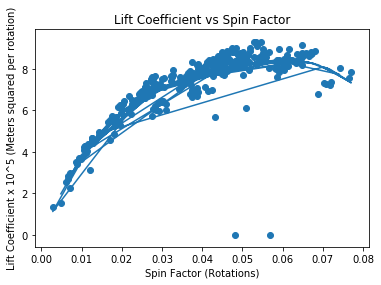

In [12]:
plt.plot(S, zpoly(S))
plt.scatter (S, CLscaled)
plt.xlabel ("Spin Factor (Rotations)")
plt.ylabel ("Lift Coefficient x 10^5 (Meters squared per rotation)")
plt.title('Lift Coefficient vs Spin Factor')

This does not seem to be a linear relationship. THere potentiall is one from spin factors 0 to about 0.02 but then it is not linear for the rest of the graph.

Text(0.5,1,'Lift Coefficient vs Spin Factor * Velocity')

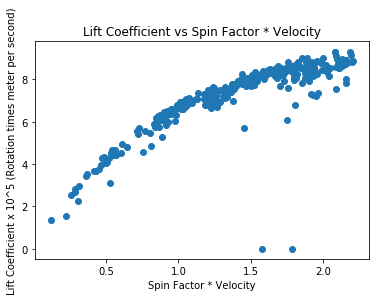

In [13]:
plt.scatter (SV, CLscaled)
plt.xlabel ("Spin Factor * Velocity")
plt.ylabel ("Lift Coefficient x 10^5 (Rotation times meter per second)")
plt.title ('Lift Coefficient vs Spin Factor * Velocity')

Out of the two graphs above, this seems to be the most linear. This graph still is not perfectly linear but it is getting a lot closer. There is a y-intercept around 1 or 2 and I think that could be due to the Reynolds number. I rememeber reading that Nathan said that the Reynolds number is also a part of the lift coefficient.

Text(0.5,1,'Lift Coefficient vs Velocity')

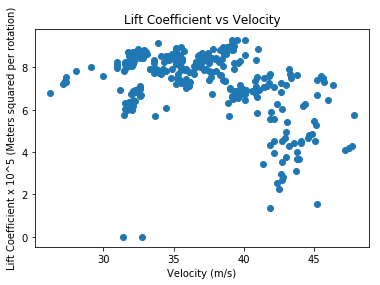

In [14]:
plt.scatter (Velo, CLscaled)
plt.xlabel ("Velocity (m/s)")
plt.ylabel ("Lift Coefficient x 10^5 (Meters squared per rotation)")
plt.title('Lift Coefficient vs Velocity')

This graph is a little interesting because there seems to be a negative relationship between the lift coefficient and the velocity.

Text(0.5,1,'Lift Coefficient vs Spin Rate')

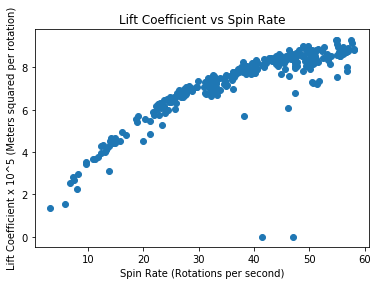

In [15]:
plt.scatter (SpinS, CLscaled)
plt.xlabel ("Spin Rate (Rotations per second)")
plt.ylabel ("Lift Coefficient x 10^5 (Meters squared per rotation)")
plt.title('Lift Coefficient vs Spin Rate')

This graph is very similar to the Lift Coefficient vs Spin Factor Times Velocity graph because the spin factor times velocity is just the radius of the ball times the spin rate.